In [1]:
import tensorflow as tf
from keras import layers
from keras.models import Model, Sequential
from keras import backend as K
from sklearn.metrics import mean_squared_error
import keras
import numpy as np
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
_optimizer = Adam(0.0002, 0.5)
#_optimizer = Adam(0.001, 0.9)
from keras import losses

# from tensorflow.keras import layers
# from tensorflow.keras.models import Model
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
from tqdm import tqdm
import os

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!ls "/content/drive/My Drive"

In [0]:
def encoder_block(_filters, _kernel_size, _strides, bn = True):
    y = Sequential()
    y.add(layers.Conv2D(filters = _filters, kernel_size = _kernel_size, 
                      strides = _strides, padding="same",
                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02)))
    if bn is True:
        y.add(layers.BatchNormalization(momentum = 0.9, epsilon=1e-5))
    y.add(layers.ReLU())
    return y

In [0]:
def encoder_net():
    y = Sequential()
    y.add(encoder_block(32, (5, 5), (4, 4), bn = False))
    y.add(encoder_block(128, (5, 5), (4, 4)))
    y.add(encoder_block(256, (5, 5), (4, 4)))
    y.add(encoder_block(256, (5, 5), (4, 4)))
#    y = encoder_block(y, 256, (5, 5), (2, 2))
#   y = encoder_block(y, 256, (5, 5), (4, 4))
#    y = encoder_block(y, 256, (5, 5), (2, 2))
#    y = encoder_block(y, 256, (5, 5), (4, 4))
#    y = encoder_block(y, 256, (5, 5), (2, 2))
#     y = layers.Flatten()(y)
#     y = layers.Dense(256, 
#                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)
#     y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
#     y = layers.ReLU()(y)
    return y

In [0]:
def decoder_block(x, _filters, _kernel_size, _strides, dropout = False):
    y = layers.Conv2DTranspose(filters = _filters, kernel_size = _kernel_size, 
                               strides=_strides, padding="same",
                               kernel_initializer=keras.initializers.RandomNormal(stddev=0.02))(x)
    y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
    if dropout is True:
        y = layers.Dropout(0.5)(y)
    y = layers.ReLU()(y)
    return y

In [0]:
def decoder_net(y):
#     y = layers.Dense(8*8*256, 
#                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)

#     y = layers.BatchNormalization(momentum = 0.9, epsilon=1e-5)(y)
#     y = layers.ReLU()(y)imgIdx = 9
#     y = layers.Reshape((8, 8, 256))(y)
#    y = decoder_block(y, 256, (5, 5), (4, 4))
#    y = decoder_block(y, 256, (5, 5), (2, 2))
#    y = decoder_block(y, 256, (5, 5), (4, 4))
#    y = decoder_block(y, 256, (5, 5), (2, 2))
    y = decoder_block(y, 256, (5, 5), (4, 4))
#    y = decoder_block(y, 256, (5, 5), (2, 2), False)
    y = decoder_block(y, 256, (5, 5), (4, 4), False)
    y = decoder_block(y, 128, (5, 5), (4, 4), False)
    #print(y._keras_shape)
    y = decoder_block(y, 32, (5, 5), (4, 4), False)
    y = encoder_block(16, (5, 5), (1, 1), bn = False)(y)
    y = layers.Conv2D(filters = 1, kernel_size = (5, 5), padding = "same",
                      activation="tanh",
                      kernel_initializer = keras.initializers.RandomNormal(stddev=0.02))(y)
    #y = layers.Softmax(axis = -1)(y)
    return y

In [0]:
def fusionnet(inTensor1, inTensor2):
    Enc = encoder_net()
    out1 = Enc(inTensor1)
    out2 = Enc(inTensor2)
    x = layers.Concatenate(axis = -1)([out1, out2])
    y = decoder_net(x)
    return y

In [0]:
def fusionnetPos(y):
    y, inTensor1, inTensor2 = y
#     # crop the input images to the same size as network output.
#     inCrop1 = layers.Cropping2D(cropping=((8, 8), (8, 8)))(inTensor1)
#     inCrop2 = layers.CroppinimgIdx = 9
    y = K.tile(y, [1, 1, 1, 3])
    y1 = layers.Multiply()([inTensor1, (1+y)/2])
    y2 = layers.Multiply()([inTensor2, 1-(1+y)/2])
    y = layers.Add()([y1, y2])
    return y

In [0]:
img1 = layers.Input(shape=(256, 256, 3))
img2 = layers.Input(shape=(256, 256, 3))
intermed = fusionnet(img1, img2) # intermed: mask layer

pred = layers.Lambda(fusionnetPos)([intermed, img1, img2])

In [26]:
'''2 outputs: 'pred' for GAN loss and 'intermed' for mask loss'''
generator = Model(inputs = [img1, img2], outputs = [pred, intermed])
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
sequential_16 (Sequential)      (None, 1, 1, 256)    2565632     input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 1, 1, 512)    0           sequential_16[1][0]              
          

In [0]:
generator.load_weights('/content/drive/My Drive/my_model_300e_5e-3_weights.h5')

HDMI 1080P COLOR 1.2X
130W 1-2''
HDMI 1080P COLOR 0.7X
500W 1-2.5''
200W  2-3''
130W
200W_rect
4.jpg
5.jpg
2.jpg
3.jpg
6.jpg
1.jpg
6
(1178, 1884, 3)


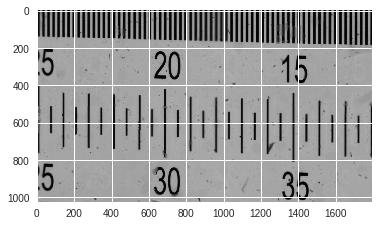

In [0]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        if 'aif' in filename:
          continue         
        print(filename)
        img = cv2.imread(os.path.join(folder,filename))

        if img is not None:
          #img = cv2.resize(img, (0,0), fx = 0.5, fy = 0.5)
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          images.append(img)
    return images

dataPath = "/content/drive/My Drive/20190222/"
for filename in os.listdir(dataPath):
  print(filename)
  if filename != '200W_rect':
    continue
  dataPath_curr = dataPath + filename + "/";
  focal_stack = load_images_from_folder(dataPath_curr)
  print(len(focal_stack))
  #focal_stack = focal_stack[:3]
  dataNum = (focal_stack[0].shape[0]//256) * (focal_stack[0].shape[1]//256)

  prediction = np.zeros((dataNum, 256, 256, 3)).astype('uint8')
  kkk = 0
  for i in range(focal_stack[0].shape[0]//256):
    for j in range(focal_stack[0].shape[1]//256):
      prediction[kkk, :, :, :] = focal_stack[0][i*256:i*256+256, j*256:j*256+256, :]
      kkk = kkk+1
  prediction = prediction/127.5-1

  x_test2 = np.zeros((dataNum, 256, 256, 3)).astype('uint8')

  for img in focal_stack:
    x_test1 = prediction
    kkk = 0
    for i in range(img.shape[0]//256):
      for j in range(img.shape[1]//256):
        x_test2[kkk, :, :, :] = img[i*256:i*256+256, j*256:j*256+256, :]
        kkk = kkk+1
    prediction, a= generator.predict([x_test1, x_test2/127.5-1])
  #   get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
  #                                     [generator.layers[-2].output])

  #   layer_output = np.array(get_layer_output([x_test1/127.5-1, x_test2/127.5-1])[0])
  
  I1 = focal_stack[0]
  I0 = np.zeros((I1.shape[0]//256*256, I1.shape[1]//256*256, 3))
  print(I1.shape)
  kkk = 0
  for i in range(I1.shape[0]//256):
    for j in range(I1.shape[1]//256):
      I0[i*256:i*256+256, j*256:j*256+256, :] = (prediction[kkk, :, :, :] + 1)/2
      kkk = kkk+1
  plt.imshow(I0)
  plt.show()
  cv2.imwrite(dataPath_curr + 'aif_300e_5e-3.jpg',cv2.cvtColor((I0*255).astype('uint8'), cv2.COLOR_RGB2BGR))

In [0]:
#   prediction = np.zeros((dataNum, 256, 256, 3)).astype('uint8')
#   kkk = 0
#   for i in range(focal_stack[0].shape[0]//256):
#     for j in range(focal_stack[0].shape[1]//256):
#       prediction[kkk, :, :, :] = focal_stack[0][i*256:i*256+256, j*256:j*256+256, :]
#       kkk = kkk+1
#   prediction = prediction/127.5-1

#   x_test2 = np.zeros((dataNum, 256, 256, 3)).astype('uint8')

#   for img in focal_stack:
#     x_test1 = prediction
#     kkk = 0
#     for i in range(img.shape[0]//256):
#       for j in range(img.shape[1]//256):
#         x_test2[kkk, :, :, :] = img[i*256:i*256+256, j*256:j*256+256, :]
#         kkk = kkk+1

#     prediction, a= generator.predict([x_test1, x_test2/127.5-1])
#   #   get_layer_output = K.function([generator.layers[0].input, generator.layers[1].input],
#   #                                     [generator.layers[-2].output])

#   #   layer_output = np.array(get_layer_output([x_test1/127.5-1, x_test2/127.5-1])[0])

In [0]:
#   I1 = focal_stack[0]
#   I0 = np.zeros((I1.shape[0]//256*256, I1.shape[1]//256*256, 3))
#   print(I1.shape)
#   kkk = 0
#   for i in range(I1.shape[0]//256):
#     for j in range(I1.shape[1]//256):
#       I0[i*256:i*256+256, j*256:j*256+256, :] = (prediction[kkk, :, :, :] + 1)/2
#       kkk = kkk+1
#   plt.imshow(I0)
#   plt.show()
#   cv2.imwrite(dataPath_curr + 'aif.jpg',cv2.cvtColor((I0*255).astype('uint8'), cv2.COLOR_RGB2BGR))

#   # kkk = 0
#   # for i in range(I1.shape[0]//256):
#   #   for j in range(I1.shape[1]//256):
#   #     I0[i*256:i*256+256, j*256:j*256+256, :] = I3[i*256:i*256+256, j*256:j*256+256, :]
#   #     kkk = kkk+1
#   # cv2.imwrite('/content/drive/My Drive/merge/img3.png',cv2.cvtColor((I0).astype('uint8'), cv2.COLOR_RGB2BGR))